In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import math
import tqdm
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from torch import nn
from cupy.cuda import Device
from text_vae.cvae import RnnVae
from text_vae.metrics import Evaluator
from sklearn.datasets.lfw import Bunch
from torch.nn.utils import clip_grad_norm_
from collections import UserList, defaultdict
from torch.optim.lr_scheduler import _LRScheduler
from text_vae.corpus import SSTCorpus, WikiText2Corpus, IMDBCorpus
from text_vae.misc import KLAnnealer, CosineAnnealingLRWithRestart, Logger, LogPlotter, reject_outliers, SamplePlotter

In [4]:
path = Bunch(
    save='vae.pt'
)

In [5]:
!nvidia-smi

Thu May 31 17:23:26 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
| 47%   67C    P2    66W / 250W |    696MiB / 11172MiB |     19%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:0A:00.0 Off |                  N/A |
| 85%   90C    P2    74W / 250W |  10608MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [6]:
args = Bunch(
    # Model
    model=Bunch(
        q=Bunch(
            d_h=64,
            n_layers=3,
            s_dropout=0.0,
            r_dropout=0.0
        ),
        g=Bunch(
            n_layers=3,
            s_dropout=0.0,
            r_dropout=0.0
        ),
        d=Bunch(
            n_filters=3
        ),
        d_z=64,
        d_c=2,
        n_len=15 + 2,  # + <bos> and <eos>
        n_vocab=10000,  # 'up to' value
        d_emb=50,
        p_word_dropout=0.5,
        freeze_embeddings=True,
    ),
    # Train
    train=Bunch(
        n_batch=64,
        n_iter_per_epoch=3000,  # n_epoch will be calcaulated based on lr setting
        grad_clipping=5,
        kl=Bunch(
            i_start=5,
            w_start=0.01,
            w_max=0.4
        ),
        lr=Bunch(
            value=1e-2,
            scheduler=Bunch(
                n_period=10,
                n_r=3,  # number of restarts in SGDR
                n_mult=2,
                lr_min=1e-3
            )
        )
    ),
    # Val
    val=Bunch(
        n_beam=5,
        coverage_penalty=True,
        n_hypot=100,
        n_ref=500
    ),
    # Env
    device_code=0
)

In [7]:
device = torch.device(
    f'cuda:{args.device_code}' 
    if args.device_code >= 0 and torch.cuda.is_available()
    else 'cpu'
)
Device(device.index).use()  # cupy for SRU to work
device

device(type='cuda', index=0)

In [8]:
# Sents with targets
# %time corpus = SSTCorpus(**args.model, n_batch=args.train.n_batch, device=device)
# LM
# %time corpus = WikiText2Corpus(**args.model, n_batch=args.train.n_batch, device=device)
# Sents with targets, `val` same as `test` (so we overfit a bit), `unlabeled` xs same as `labeled` xs
%time corpus = IMDBCorpus(**args.model, n_batch=args.train.n_batch, device=device)
corpus.size('train'), corpus.size('val'), corpus.size('test')

CPU times: user 44 s, sys: 660 ms, total: 44.7 s
Wall time: 44.7 s


(25000, 25000, 25000)

In [9]:
model = RnnVae(
    **args.model, 
    x_vocab=corpus.vocab('x')
).to(device)
model

RnnVae(
  (x_emb): Embedding(10000, 50, padding_idx=0)
  (encoder_rnn): SRU(
    (rnn_lst): ModuleList(
      (0): SRUCell()
      (1): SRUCell()
      (2): SRUCell()
    )
  )
  (q_mu): Linear(in_features=64, out_features=64, bias=True)
  (q_logvar): Linear(in_features=64, out_features=64, bias=True)
  (decoder_rnn): SRU(
    (rnn_lst): ModuleList(
      (0): SRUCell()
      (1): SRUCell()
      (2): SRUCell()
    )
  )
  (decoder_a): SelfAttention(
    (linear_in): Linear(in_features=66, out_features=66, bias=False)
    (linear_out): Linear(in_features=132, out_features=66, bias=False)
  )
  (decoder_fc): Linear(in_features=66, out_features=10000, bias=True)
  (disc_cnn): CNNEncoder(
    (_activation): ReLU()
    (conv_layer_0): Conv1d(2, 3, kernel_size=(2,), stride=(1,))
    (conv_layer_1): Conv1d(2, 3, kernel_size=(3,), stride=(1,))
    (conv_layer_2): Conv1d(2, 3, kernel_size=(4,), stride=(1,))
    (conv_layer_3): Conv1d(2, 3, kernel_size=(5,), stride=(1,))
  )
  (encoder): Module

In [10]:
sample_params = dict(
    n_beam=args.val.n_beam,
    coverage_penalty=args.val.coverage_penalty
)
sampler = lambda s: corpus.reverse(model.sample_sentence(s, **sample_params)[2])
evaluator = Evaluator(corpus, args.val.n_ref, sample_params=sample_params)
sampler(1)[0]  # sanity check

'sleep admirable’footsteps story hulk sings wayne punch thirties breakfast paint homage fascination baseball composed'

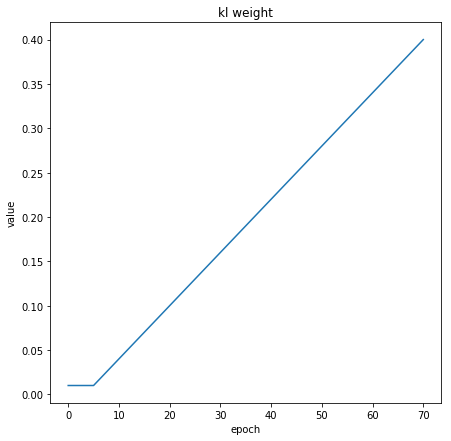

In [11]:
n_epoch = sum(args.train.lr.scheduler.n_period * (args.train.lr.scheduler.n_mult ** i)
              for i in range(args.train.lr.scheduler.n_r))
kl_annealer = KLAnnealer(**args.train.kl, n_epoch=n_epoch)
xs = np.linspace(0, n_epoch, num=n_epoch + 1)
ts = np.array([kl_annealer(i) for i in xs])
plt.figure(figsize=(7, 7))
plt.ylabel('value')
plt.xlabel('epoch')
plt.title('kl weight')
plt.plot(xs, ts);

In [12]:
get_params = lambda: (p for p in model.vae.parameters() if p.requires_grad)
trainer = optim.Adam(get_params(), lr=args.train.lr.value)
lr_scheduler = CosineAnnealingLRWithRestart(trainer, **args.train.lr.scheduler)

In [ ]:
model.train()
batcher = corpus.batcher('train', 'unlabeled')
T = tqdm.tqdm_notebook(range(n_epoch))
# n_iter = min(args.train.n_iter_per_epoch, corpus.size('train') // args.train.n_batch)
n_iter = args.train.n_iter_per_epoch
elog, ilog = Logger(), Logger()

for epoch in T:
    # Epoch start
    kl_weight = kl_annealer(epoch)
    
    # Iters
    for i in range(n_iter):
        # Forward
        x = next(batcher)
        kl_loss, recon_loss = model(x, use_c_prior=True)
        loss = kl_weight * kl_loss + recon_loss
        
        # Backward
        trainer.zero_grad()
        loss.backward()
        clip_grad_norm_(get_params(), args.train.grad_clipping)
        trainer.step()
        
        # Log
        lr = trainer.param_groups[0]['lr']
        ilog.append({
            'epoch': epoch,
            'kl_loss': kl_loss.item(),
            'recon_loss': recon_loss.item(),
            'loss': loss.item(),
            'kl_weight': kl_weight,
            'lr': lr
        })
        
        # Update T
        kl_loss_value = np.mean(reject_outliers(ilog['kl_loss'][-args.train.n_iter_per_epoch:]))
        recon_loss_value = np.mean(reject_outliers(ilog['recon_loss'][-args.train.n_iter_per_epoch:]))
        loss_value = np.mean(reject_outliers(ilog['loss'][-args.train.n_iter_per_epoch:]))
        postfix_strs = []
        postfix_strs.append(f'i={i}/{n_iter}')
        postfix_strs.append(f'kl_loss={kl_loss_value:.5f}')
        postfix_strs.append(f'recon_loss={recon_loss_value:.5f}')
        postfix_strs.append(f'loss={loss_value:.5f}')
        postfix_strs.append(f'klw={kl_weight:.3f} lr={lr:.5f}')
        T.set_postfix_str(' '.join(postfix_strs))
        T.refresh()
    
    # Log
    sent = sampler(1)[0]
    bleu = evaluator.bleu(model, args.val.n_hypot, 'val')
    self_bleu = evaluator.self_bleu(model, args.val.n_hypot)
    ppl = evaluator.perplexity(model, 'val')
    elog.append({
        **{k: v for k, v in ilog[-1].items() if 'loss' not in k},
        'kl_loss': kl_loss_value,
        'recon_loss': recon_loss_value,
        'loss': loss_value,
        'sent': sent,
        'bleu': bleu,
        'self_bleu': self_bleu,
        'ppl': ppl
    })
    
    # Print result
    bleu_5, self_bleu_5 = bleu['5-gram'], self_bleu['5-gram']
    print(f"[epoch={epoch}, bleu_5={bleu_5:.3f} self_bleu_5={self_bleu_5:.3f} ppl={ppl:.3f}]: '{sent}'")
    
    # Epoch end
    lr_scheduler.step()

[epoch=0, bleu_5=0.210 self_bleu_5=0.306 ppl=inf]: 'this "doctor in the prison <unk> <unk> (california francisco francisco francisco francisco francisco <unk>'
[epoch=1, bleu_5=0.067 self_bleu_5=0.256 ppl=inf]: 'pecker teach madison duke <unk> a crowded with a dangerous antics in'
[epoch=2, bleu_5=0.046 self_bleu_5=0.239 ppl=inf]: 'vignettes estate estate estate estate soviet plant plant plant plant plant plant plant estate") <unk>'
[epoch=3, bleu_5=0.053 self_bleu_5=0.232 ppl=inf]: '_roger ebert affected * fido antwone affected * advantage claire laboratory laboratory laboratory laboratory <unk>'
[epoch=4, bleu_5=0.053 self_bleu_5=0.204 ppl=inf]: 'rob brown > fist (<unk> <unk> <unk> corridors of cannes ridden glory mechanic'
[epoch=5, bleu_5=0.037 self_bleu_5=0.204 ppl=inf]: 'i addiction structure advantage missile advantage field valentine field happy happy happy speechless speechless speechless speechless'
[epoch=6, bleu_5=0.066 self_bleu_5=0.248 ppl=inf]: 'im not not <unk> bonnie <

In [ ]:
plotter = LogPlotter(elog)
plotter.grid([
    'kl_loss', 'recon_loss',
    'loss', 'lr',
    'bleu', 'self_bleu',
    'epoch', 'ppl'
])

In [ ]:
splotter = SamplePlotter(corpus.vocab('x'), model)
splotter.plot()

In [ ]:
%time evaluator.bleu(model, args.val.n_hypot, 'train')

In [ ]:
%time evaluator.bleu(model, args.val.n_hypot, 'test')

In [ ]:
evaluator.self_bleu(model, args.val.n_hypot)

In [ ]:
torch.save((args, model), path.save)

In [ ]:
!du -sh {path.save}